# Capstone project by Jordi Figueras i Ventura

# Towards hail detection from satellite images using machine learning

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import PIL.Image as Image

### Technical note:

We have performed all the computation using remote servers. The datasets we are dealing with are rather large and therefore the computation times were quite long as well. Consequently it was impractical to put all the computations in a single notebook among other things because the risk of losing the connection to the server while processing was too high. For this reason it was decided to split the code in several notebooks and python scripts. This notebook provides an overview of the project and a guideline to the different notebooks.

## 1) The problem

Hail is one of the most damaging natural hazards. The exact location of hail and the hail size is very difficult to predict. Typically the detection of hail over large areas is perfomed from weather radar data. Hail pads or more sophisticated hail sensors on the ground are also very useful to precisely quantify parameters such as the hail size, the kinetic energy, etc. but, because hail is a rare and localized phenomenon, ground station networks cannot provide sufficient areal coverage and, therefore, primarily serve as benchmark for remote sensing methods.

Weather radar networks cover relatively well densely inhabited areas of developed countries but there are wide areas of the Earth with poor coverage. In particular in developing countries, which are also the most vunerable to natural hazards. Moreover, weather radar networks tend to have a national scope and, if continental scale studies of hail are desired, the data may not be readily available and it will definitely not be homogeneous since each country operates different networks with different specifications.

Satellite data, on the other hand, covers the entire globe and can be accessed with relative easiness. Therefore, it would be convenient to identify structures in satellite images that are strong indicators of the presence of hail. Cloud top structures observable from satellites indicating severe weather include overshooting tops (OT), cold rings, U- and V-shapes, and above anvil plumes. 

According to [Wikipedia](https://en.wikipedia.org/wiki/Overshooting_top) an OT is a dome-like protrusion out of the top of the anvil of a thunderstorm and into the lower stratosphere (See picture below). It is formed in areas of strong updraft. OTs are strong indicators of severe weather (lightning, wind gusts, heavy rain, hail and even tornadoes), particularly if they last for more than 10 min.

<img src="./figures/Cumulonimbus13_-_NOAA.jpg" align="center"/>
<center><i>Picture of a cumulonimbus with a cloud overshooting top. Source: <a href="https://www.noaa.gov/">National Oceanic and Atmospheric Administration NOAA]</a><\i><\center>

Traditionally, OTs have been identified by humans in satellite images. They can be seen as "cauliflower-like" structures when the sun is close to the zenith. At lower elevation angles, the shadow of the OT is easily observable in the visibile channel satellite image. This is a cumbersome process and prone to error because a forecaster needs to constantly monitor new satellite imaginery. It is also a time-consuming process, specially if the forecaster is responsible to issue warnings for a large area. Furthermore, manually identifying and delimiting OTs does not integrate well with the automatized processess used in modern severe weather warning systems. For this reasons, an automatic identification of OTs is highly desirable. 

## 2) The data

### (a) Clear overview of your data

Mainly, data from two different systems are used in this project: Satellite and weather radar network.

#### Satellite data

First and foremost, data from the [Meteosat 2nd generation (MSG)](https://www.eumetsat.int/website/home/Satellites/CurrentSatellites/Meteosat/index.html) satellites will be used. MSG is a network of 4 satellites placed at geostationary orbit (36000 km above Earth). Two of them are operational and the other two are used as a backup. They are owned and operated by the EUMETSAT consortium.

On board of each satellite there is the Spinning Enhanced Visible and Infrared Imager (SEVIRI). This instrument is a radiometer sensing 12 different spectral channels, 8 thermal infrared (at wavelengths centered at 3.9, 6.2 (for water vapor), 7.3 (for water vapor), 8.7, 9.7, 10.8, 12.0 and 13.4 $\mu m$) and 4 visible and near-infrared (at wavelengths centered at 0.6, 0.8 and 1.6 (ner-infrared) $\mu m$, the high resolution visible is wide bandwidth). The visible and near-infrared channels are sensitive to the solar radiation (hence only available during daylight) and the observations are usually provided as reflectance in percentage. The infrared channels are sensitive to the thermal emission of the Earth, usually expressed as brightness temperature in K, except for the 3.9 channel that is sensitive to both. Each channel is more sensitive to a particular characteristic of the atmosphere.

11 of those channels have a sub-satellite resolution of 3 km while one of the visible ones has a 1 km resolution. Due to the viewing angle, in Europe, the resolution in North-South direction is 1.5 times larger than the sub-satellite resolution. The latest MSG satellite provides an image of the full disk every 15 min (full disk service). Another MSG satellite provides the Rapid Scan Service (RSS), images of the upper disk (i.e. roughly centered over Europe) every 5 min.

Since 2018 MeteoSwiss has pre-processed and archived this satellite data. SEVIRI is available over 99.7% of the time. The pre-processing consist on a parallax correction, the transformation of the data into Swiss coordinates and a cropping of the images to a smaller area centered on Switzerland that corresponds to the weather radar network domain explained below. Due to the satellite viewing geometry, high clouds appear to be further north on the Northern hemisphere. When performing the parallax correction, pixels of elevated clouds are shifted to the south, leaving missing values. In our files, those are interpolated with nearest neighbour.

Data from 2.5 convective seasons (roughly from April to September) are readily available. That means that there are images covering 16 months with a 5 min resolution, that is 288 images per day. Therefore, roughly speaking there are 155520 images with information. Obviously not all these images are of interest. Furthermore, the visible and near-infrared channels only provides information during day time, hence roughly half of the images are available for the daylight detection. We keep all available images that have a cloud top structure indicating severe weather (in particular overshooting tops) according to the specifications below.

<center><img src="./figures/Satellite.png"><\center>
<center><i>Satellite image with two overshooting tops marked with arrows. Left: High resolution visible. Right: infrared 10.8</i><\center>

#### Weather radar data

The other dataset is provided by the MeteoSwiss owned and operated [Weather Radar Network](https://www.meteoswiss.admin.ch/home/measurement-and-forecasting-systems/atmosphere/weather-radar-network.html). This network consists of 5 Doppler polarimetric weather radars (Albis, La Dole, Lema, Plaine Morte and Weissflug) distributed within Switzerland so that they cover Switzerland and the surrounding area (see map below).

<img src="./figures/MeteoSwiss_radar_network.jpg" align="center"/>
<center><i>MeteoSwiss Weather Radar Network</i><\center>
    

Each weather radar provides, among other data, polarimetric and Doppler moments (horizontal reflectivity, differential reflectivity, differential phase, copolar correlation coefficient Doppler velocity and Doppler spectral width) over an area up to a distance of 246 km with an initial resolution of 83.3 m in range and 1° beam width. The radars scan a complete volume space every 5 min. The scanning strategy consists in turning horizontally the radar antenna at a fixed elevation angle until the antenna has performed a complete revolution. It is then steered to another elevation angle and the process is repeated. A total of 20 different elevations ranging from -0.2° to 40° form a volume scan.

Out of the data from the 5 individual radars, a composite covering a 3D volume over Switzerland and the surrounding area is created. This composite has 1 km horizontal resolution and has 93 vertical levels separated by 200 m and ranging from 1.5 to 20 km MSL. A value for each grid point (i.e. a 1 km x 1 km x 200 m cube) is assigned using all radar measurements within the cube. The assigment can be performed using any statistic such as the maximum, the median, the mean, etc. The radar composite covers an area of 710 km from West to East and 640 km from South to North centered in Switzerland. Pixels beyond the radar range are simply filled with NaNs. From this composite, secondary products such as rainfall rate on the ground are generated.

The radar-derived dataset that will be used in this project is the Probability of Hail (POH) on the ground. This product is generated out of the 3D composite of radar reflectivity and an estimation of the altitude of the 0°C isotherm above mean sea level provided by the numerical weather prediction (NWP) model COSMO-1. The 0°C isotherm is defined as the first altitude where the air temperature is equal to 0°C when moving from the top to the bottom of the atmosphere. Based on the 3D composite of radar reflectivity, the echo-top 45 dBZ is estimated. The echo-top 45 dBZ is defined as the highest altitude where a reflectivity level of 45 dBZ or more is reached. The basic parameter that is computed to get POH is the height difference between the 0°-isotherm and the echo-top 45 dBZ altitude. An empirical relationship is used to estimate the probability of hail on the ground from this height difference. The POH is proportional to the height difference, i.e. the higher the difference the higher the probability of hail. POH is computed in real-time and archived since its operational implementation in 2004.

The figure below shows an example of daily accumulated POH for the 21st of July 2020. When the POH is very high (i.e. on the order of 90%) there is also a very high probability that an OT can be observed in the satellite images. The areas with POH above 90% constitute our targets

<center><img src="./figures/POH20203.gif" align="center"/><\center>
<center><img src="./figures/TRT_color_poh.gif" align="center"/><\center>
<center><i>Daily maximum POH for day 21 July 2020<\i><\center>

## Summary of the data availability

As it will be shown in the sections below, from the archive of POH data we obtained a total of 5060 images containing pixels with POH above 90%. Those images were taken over 185 days in the 3-year period examined. However, due to gaps in the satellite data archive and the presence of corrupted data in some files only 4351 images are available for the exercise.

### (b) Data management and pre-processing

Satellite data at MeteoSwiss is stored in [NETCDF (network Common Data Form)](https://www.unidata.ucar.edu/software/netcdf/) format and compliant with the [Climate and Forecast (CF)](http://cfconventions.org/) Conventions and metadata. 

POH information is stored in a proprietary format called METRANET. The files have a text header with metadata and a binary part with compressed data. The data is coded in 1 byte, therefore it has 256 values ranging from 0 to 100%.

We examine data from 2018, 2019 and 2020. The data analyzed goes from 1st April to 30 September (i.e. 183 days) for years 2018 and 2019 and from 1st April to 31 July (i.e. 122 days) for 2020. We have therefore a total of 488 days. Data is collected every 5 minutes, so there are 288 images per day. Hence the total number of images usable is 140544.

All original satellite images and POH data are mapped in Swiss coordinates and cover an area of 710 x 640 km with a resolution of 1 $km^2$. We have delimited an area covering Switzerland that goes roughly from 45.7° to 48° latitude and 5.5° to 11° longitude. This allows to tackle the problem of not having radar data in all the original area. Furthermore, in this reduced area, POH is more precise since data from many radars overlap. The resultant images have 448x256 pixels.

All POH time steps have been examined and the time steps that contain at least one pixel with POH 90% or above within the area of interest have been written in a .cvs file. This has been performed using the MeteoSwiss-developed [Pyrad software package](https://github.com/meteoswiss-mdr/pyrad) of which I am the main developer. During the EDA, the subset of hail time steps occurring during daylight have been identfied. This subset constitutes the database of potentially useful images.

Next, out of all the suitable timesteps a target dataset have been generated. For each time step a POH90 mask have been generated. It has 3 values: 0 where no POH was computed, 1 for POH below 90% at 2 for POH equal or above 90%. The POH90 area for each pixel has been expanded to equal the lower effective resolution of the satellite imaginery (i.e. 3x4.5 km). The resultant data is stored in a netcdf file with a file for each time step of interest.

The primary goal of this project is the development of a retrieval during day time, when the high resolution visible and the near-infrared channels are available. OTs are observable by naked eye in the HRV channel. Another important channel is the infrared 10.8 $\mu m$ because it gives a good estimate of cloud top temperature (and therefore cloud top height). From the case studies in section 3 we have observed that the difference between the infrared channels Water vapour 6.2 and 10.8 $\mu m$ (so called window channel) is also a good indicator of the presence of OTs. These 3 features have been used in the past for the detection of OTs. 

Again, Pyrad has been used to pre-process the satellite data. The pre-processing consisted in computing the differences between the WV_062 and IR_108 channels, normalize the HRV channel by the solar zenith angle and cropping the images of all 3 variables to the area of interest. As it will be discussed later on, for the random forest family of models the local standard deviation, i.e. the texture, over a 7x7 window is also used. The textures of all 3 variables have also been computed using Pyrad. For convenience, each feature has been stored in a separate netcdf file. At a later stage, a 4th variable (and its texture), the infrared 1.6$\mu m$ channel have been added to the dataset.

It should be noticed that the computation of the texture created an artifact. Due to the limited quantization of the numpy data types, in certain situations, when the local variance was close to 0, it resulted in very small negative variance values and consequently non-valid values of standard deviation. The extent of the issue have been analyzed in [notebook 01_data_check](./01_data_check.ipynb). There were many IR_108 texture images affected but usually only few pixels on each image and in areas not relevant were affected. The window channel was much less affected whereas the HRV channel only had two files affected. Visual inspection of these two files showed that those contained corrupted data and were removed from the archive. It was decided to keep the rest of the files in the archive and simply remove the individual pixels affected since few were in areas of interest.

The pre-processed files are stored in a hierarchical folder structure where the root is the day where hail occurred and there are separate folders for each image. An example of this structure and the files that contain can be found in ./data/MSG_ML/. Due to the size of the archive the entire dataset has not been uploaded in this repository but it is available on demand. 

## 3) Exploratory data analysis (EDA)

### (a) Preliminary EDA

We have looked for data with a Probability of Hail at least above 90%, which is a very good indicator for hail on the ground. We found that there are 3820 images in 2018, 3063 images in 2019 and 1554 images in 2020 that have at least one POH90 pixel in the area of interest (total 8437).

We are primarily interested in images taken during daylight because it is when the high resolution visible channel provides information. We have defined a daylight image as an image taken when the sun elevation over the horizon is at least 10° over the entire region delimited by the coordinates above. Night time images are defined as when the sun elevation over the horizon is below 0° in all the region and the rest are considered images taken during the transition between day and night.

There are a total of 5060 satellite images taken during day light. The distribution of the number of POH90 pixels within the delimited region is skewed towards 1. There are 430 images with just 1 POH90 pixel, 329 with 2, 238 with 3, 215 with 4 and 157 with 5. Hence, 27% of the images have 5 or less POH90 pixels. The maximum number of POH90 pixels in an image is 705.

In [2]:
# read the 3 CSV files containing POH statistics
df_2018 = pd.read_csv('./csv_files/2018_POH_above_90_percent.csv', usecols=['nominal time', 'day/night', 'npixels with POH > 90%'])
df_2018['nominal time'] = pd.to_datetime(df_2018['nominal time'])
print('Number of time steps with POH > 90% in 2018:', df_2018.shape[0])

df_2019 = pd.read_csv('./csv_files/2019_POH_above_90_percent.csv', usecols=['nominal time', 'day/night', 'npixels with POH > 90%'])
df_2019['nominal time'] = pd.to_datetime(df_2019['nominal time'])
print('Number of time steps with POH > 90% in 2019:', df_2019.shape[0])

df_2020 = pd.read_csv('./csv_files/2020_POH_above_90_percent.csv', usecols=['nominal time', 'day/night', 'npixels with POH > 90%'])
df_2020['nominal time'] = pd.to_datetime(df_2020['nominal time'])
print('Number of time steps with POH > 90% in 2020:', df_2020.shape[0])

df = pd.concat([df_2018, df_2019, df_2020])
print('Total number of time steps with POH > 90%:', df.shape[0])
df.head()

Number of time steps with POH > 90% in 2018: 3820
Number of time steps with POH > 90% in 2019: 3063
Number of time steps with POH > 90% in 2020: 1554
Total number of time steps with POH > 90%: 8437


nominal time day/night  npixels with POH > 90%
0 2018-04-04 11:10:00       day                     1.0
1 2018-04-04 11:20:00       day                     1.0
2 2018-04-04 11:25:00       day                    15.0
3 2018-04-04 11:45:00       day                     1.0
4 2018-04-04 12:10:00       day                     1.0

In [3]:
# separate the data frame into day, night and transition. Check the number of images
df_day = df[df['day/night'] == 'day']
df_night = df[df['day/night'] == 'night']
df_trans = df[df['day/night'] == 'transition']
print('day light images:', df_day.shape[0])
print('night time images:', df_night.shape[0])
print('transition images:', df_trans.shape[0])

day light images: 5060
night time images: 2123
transition images: 1254


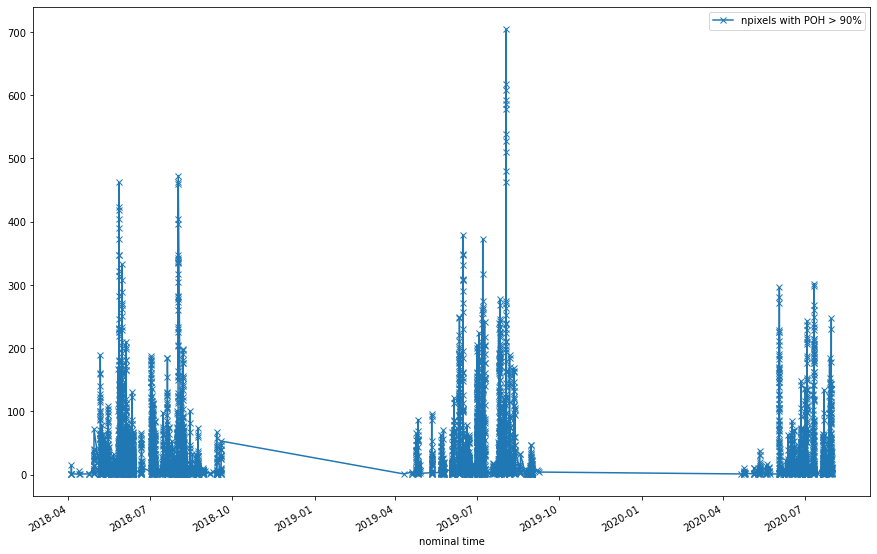

In [4]:
# Plot the evolution of the number of POH90 pixels in the daylight data
df_day.plot(x='nominal time', y='npixels with POH > 90%', marker='x', figsize=(15, 10))
plt.show()

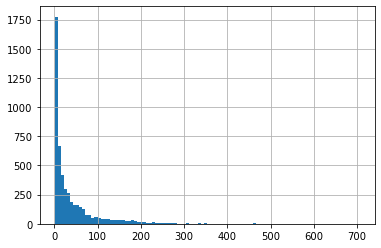

In [5]:
# Plot a histogram of the number of POH90 pixels in daylight images
df_day['npixels with POH > 90%'].hist(bins=100)
plt.show()

In [6]:
# Check how many images contain few POH90 pixels
print('Images with 1 pixel:', df_day[df_day['npixels with POH > 90%'] == 1].shape[0])
print('Images with 2 pixel:', df_day[df_day['npixels with POH > 90%'] == 2].shape[0])
print('Images with 3 pixel:', df_day[df_day['npixels with POH > 90%'] == 3].shape[0])
print('Images with 4 pixel:', df_day[df_day['npixels with POH > 90%'] == 4].shape[0])
print('Images with 5 pixel:', df_day[df_day['npixels with POH > 90%'] == 5].shape[0])

Images with 1 pixel: 430
Images with 2 pixel: 329
Images with 3 pixel: 238
Images with 4 pixel: 215
Images with 5 pixel: 157


In [7]:
df_day_aux = df_day.set_index('nominal time')
df_day_aux = df_day_aux.drop(columns='day/night')
df_day_aux.head()

npixels with POH > 90%
nominal time                               
2018-04-04 11:10:00                     1.0
2018-04-04 11:20:00                     1.0
2018-04-04 11:25:00                    15.0
2018-04-04 11:45:00                     1.0
2018-04-04 12:10:00                     1.0

The visible image has a different luminosity depending on the sun elevation. Therefore knowing the diurnal cycle of POH90 pixels is relevant. From the analysis below we can conclude that most hail occurs in the afternoon. The maximum of hail pixels occurs at 15:55UTC.

In [8]:
# Number of pixels by time
by_time = df_day_aux.groupby(df_day_aux.index.time).sum()
by_time.tail()

npixels with POH > 90%
17:35:00                  2947.0
17:40:00                  2526.0
17:45:00                  1991.0
17:50:00                  1210.0
17:55:00                   916.0

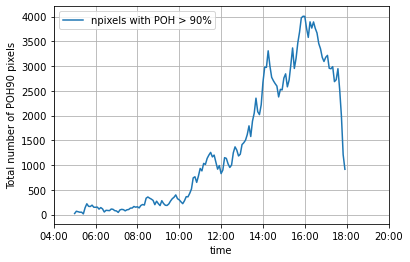

In [9]:
hourly_ticks = 60*60*np.arange(4, 21, 2)
by_time.plot(xticks = hourly_ticks)
plt.ylabel('Total number of POH90 pixels')
plt.grid()
plt.show()

In [10]:
by_time[by_time['npixels with POH > 90%'] == by_time['npixels with POH > 90%'].max()]

npixels with POH > 90%
15:55:00                  4006.0

Performing a similar analysis we can conclude that the month where most hail occurs by far is July.

In [11]:
# Number of pixels by month
by_month = df_day_aux.groupby(df_day_aux.index.month).sum()
by_month

npixels with POH > 90%
nominal time                        
4                             1887.0
5                            31832.0
6                            42942.0
7                            91402.0
8                            40109.0
9                              923.0

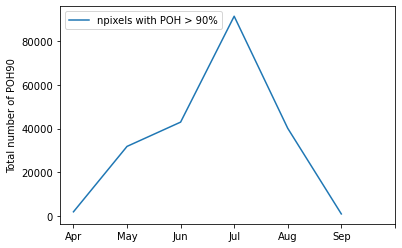

In [12]:
by_month.index = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
monthly_ticks = np.arange(7)
by_month.plot(xticks=monthly_ticks)
plt.ylabel('Total number of POH90')
plt.show()

In [13]:
# Check the 30 time steps with most POH90 pixels
df_day.sort_values(by='npixels with POH > 90%', ascending=False).head(30)

nominal time day/night  npixels with POH > 90%
2452 2019-08-02 11:10:00       day                   705.0
2458 2019-08-02 11:40:00       day                   618.0
2450 2019-08-02 11:00:00       day                   608.0
2454 2019-08-02 11:20:00       day                   593.0
2453 2019-08-02 11:15:00       day                   586.0
2451 2019-08-02 11:05:00       day                   579.0
2456 2019-08-02 11:30:00       day                   538.0
2459 2019-08-02 11:45:00       day                   527.0
2455 2019-08-02 11:25:00       day                   511.0
2449 2019-08-02 10:55:00       day                   480.0
2774 2018-08-01 17:35:00       day                   473.0
2760 2018-08-01 16:25:00       day                   462.0
2457 2019-08-02 11:35:00       day                   462.0
708  2018-05-27 16:15:00       day                   462.0
2773 2018-08-01 17:30:00       day                   460.0
714  2018-05-27 16:45:00       day                   424.0
715  2018-05-27 16:50:00       day                   419.0
2761 2018-08-01 16:30:00       day                   405.0
713  2018-05-27 16:40:00       day                   404.0
2772 2018-08-01 17:25:00       day                   396.0
709  2018-05-27 16:20:00       day                   390.0
614  2019-06-15 14:20:00       day                   379.0
1724 2019-07-07 14:10:00       day                   373.0
712  2018-05-27 16:35:00       day                   373.0
613  2019-06-15 14:15:00       day                   349.0
716  2018-05-27 16:55:00       day                   348.0
2763 2018-08-01 16:40:00       day                   348.0
615  2019-06-15 14:25:00       day                   347.0
710  2018-05-27 16:25:00       day                   347.0
2754 2018-08-01 15:55:00       day                   342.0

The 30 images with most POH90 pixels correspond to just 5 days: 2019-08-02, 2018-08-01, 2018-05-27, 2019-06-15 and 2019-07-07

# Example of images: 2019-08-02

On Day 2 August 2019, the most affected area was the Po Valley. The episode was first visible at 5:45 UTC. The most intense episode lasted roughly from 9 to 14 UTC. There were several [reports](http://www.meteoweb.eu/foto/maltempo-nord-grandine-lombardia-treviso-friuli-foto-video/id/1296890/#6) in the media of large hail and wind gusts in the area 

First image:  2019-08-02 00:15:00
Last image:  2019-08-02 13:25:00


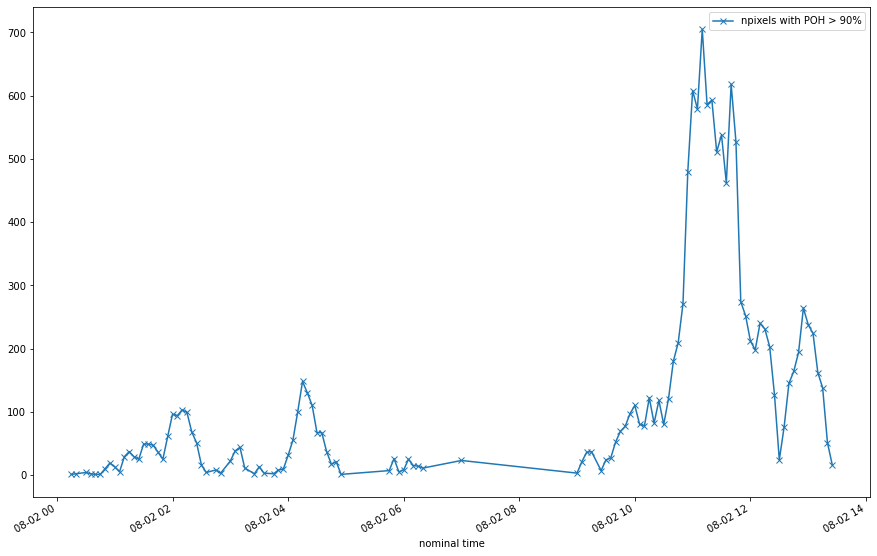

In [14]:
# Plot day 2019-08-02
df_20190802 = df[(df['nominal time']>=datetime.datetime(2019, 8, 2)) & (df['nominal time']<=datetime.datetime(2019, 8, 3))]
df_20190802.plot(x='nominal time', y='npixels with POH > 90%', marker='x', figsize=(15, 10))
print('First image: ', df_20190802['nominal time'].iloc[0])
print('Last image: ', df_20190802['nominal time'].iloc[-1])
plt.show()

The images below were taken at the moment of maximum extension of POH90. As it can be seen the areas of high POH correlate well with the "cauliflower"-shaped structure visibile in the HRV channel.

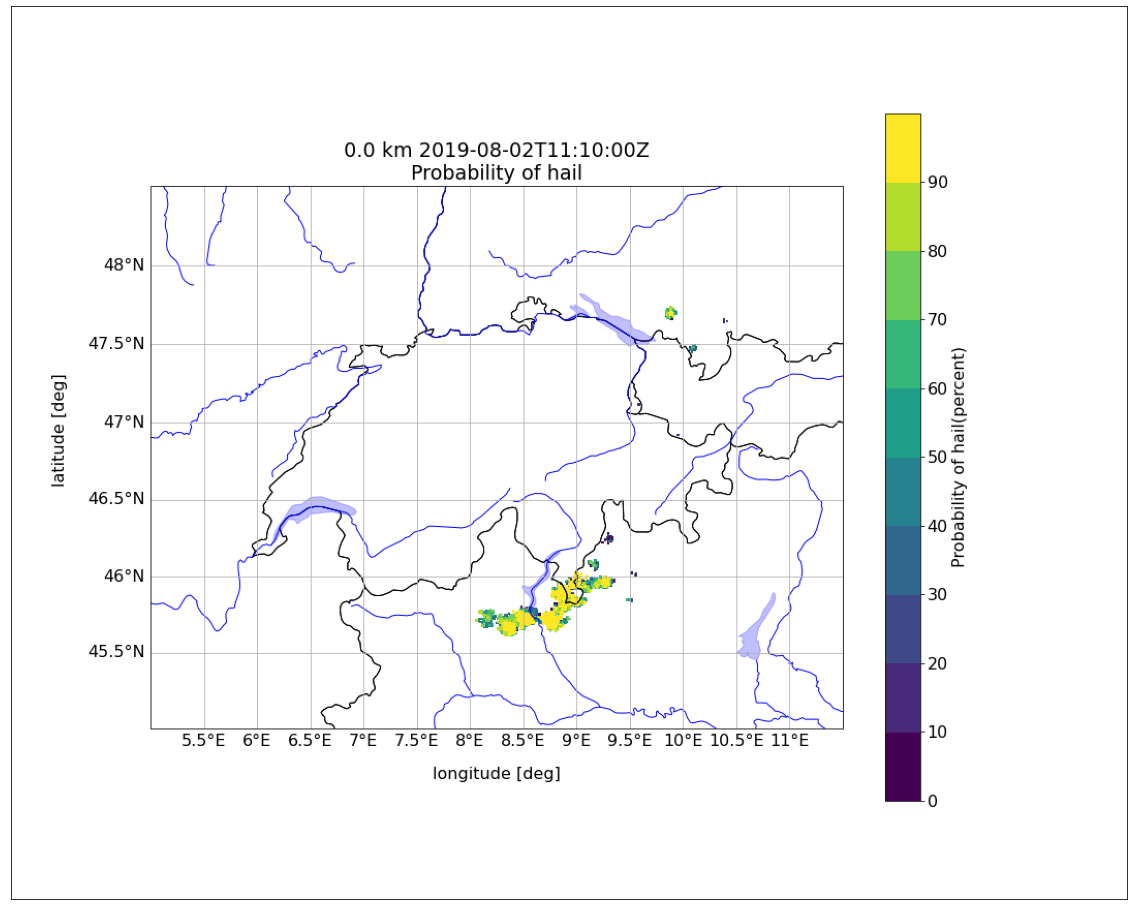

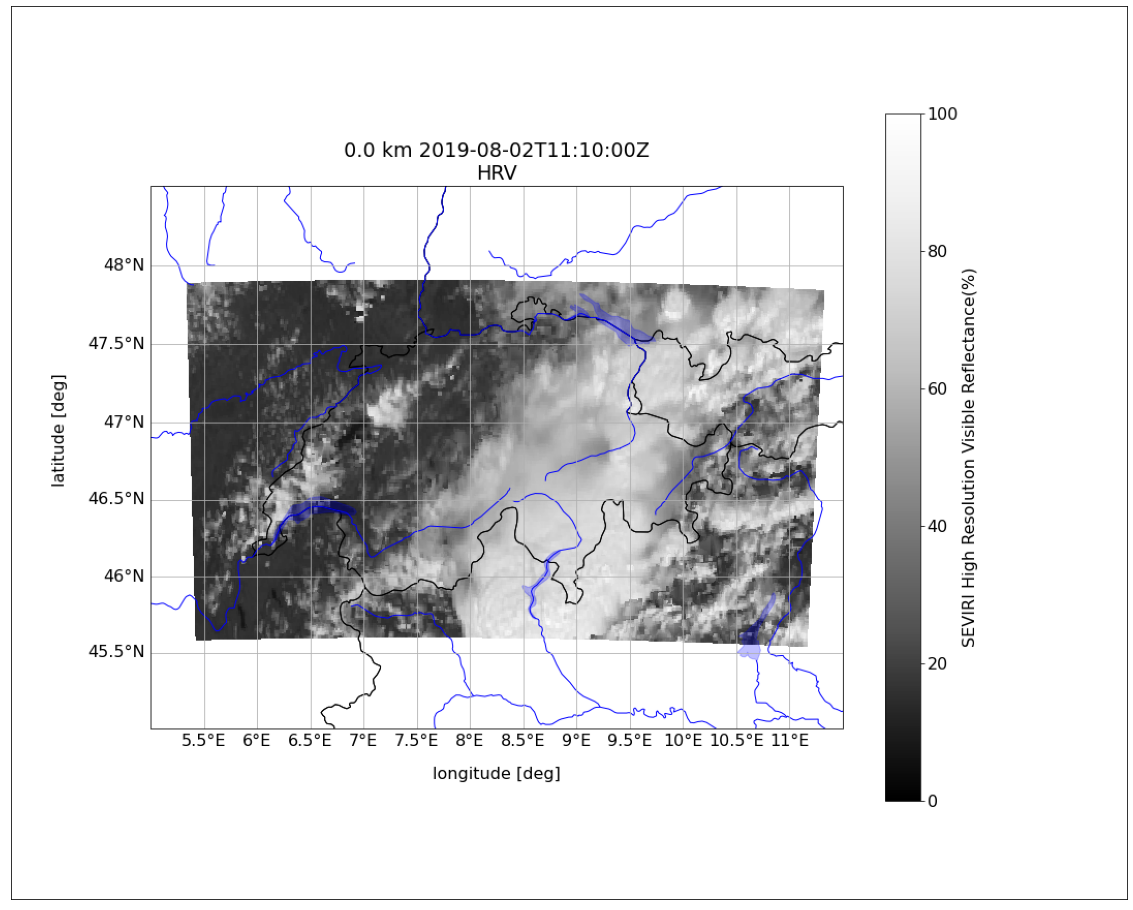

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
img = Image.open('./figures/20190802/20190802111000_surface_RAW_GRID_POH_l0.png')
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
img = Image.open('./figures/20190802/20190802111000_surface_RAW_GRID_HRV_l0.png')
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

We plot below the visible and near-infrared channels at the same time step as above. The HRV channel is best suited to capture the structure of the overshooting top. The VIS 0.6 $\mu m$ and VIS 0.8 $\mu m$ channel show similar structures, but are less suited due to their lower resolution. The IR 1.6 $\mu m$ channel provides information to destinguish the cloud phase. Water clouds appear brighter than ice clouds.

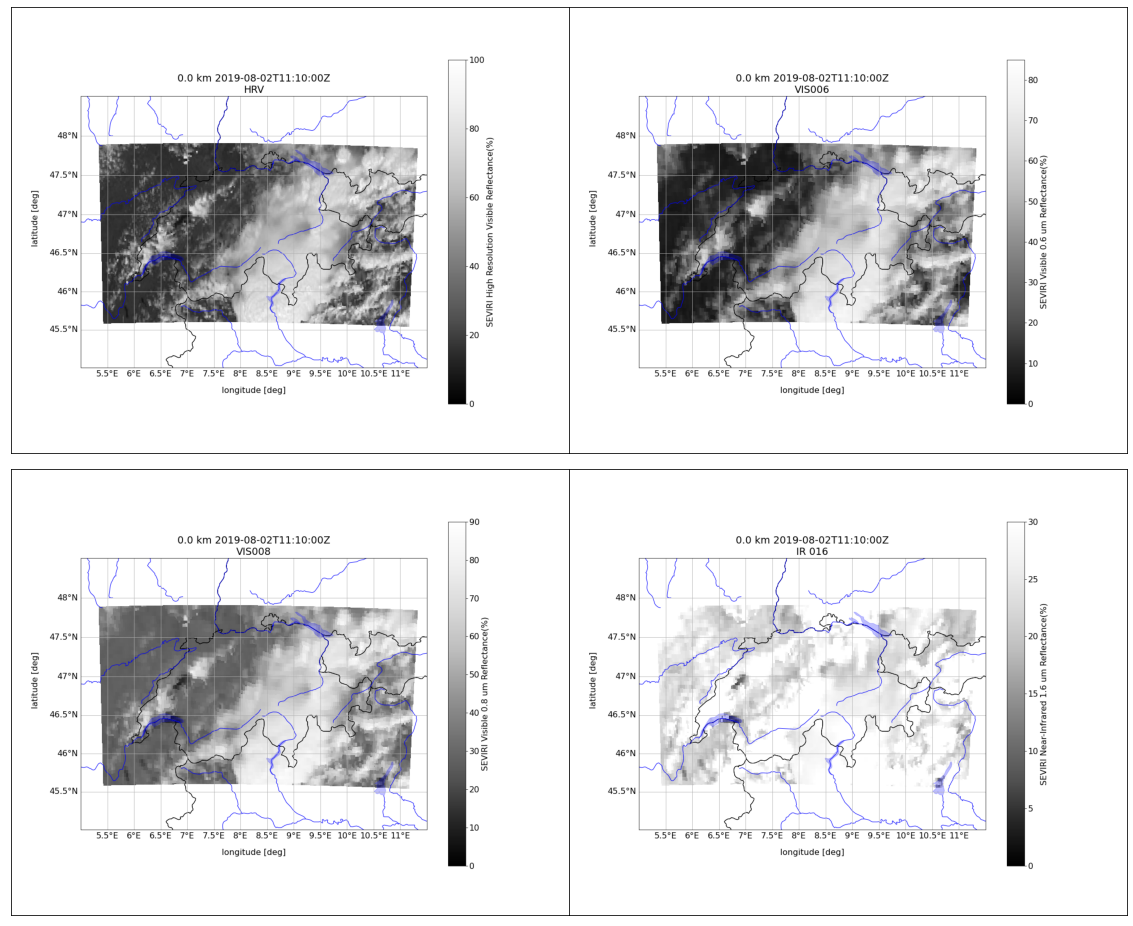

In [16]:
variable = ['HRV', 'VIS006', 'VIS008', 'IR_016']
ncols = 2
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 17))

for i, var in enumerate(variable):
    img = Image.open('./figures/20190802/20190802111000_surface_RAW_GRID_'+var+'_l0.png')
    irow = int(i/ncols)
    icol = int(i%ncols)
    axes[irow, icol].imshow(img)
    axes[irow, icol].set_xticks([])
    axes[irow, icol].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

For completion we plot below the infrared channels. Most of them exhibit lower values in the area adjacent to the overshooting top. Therefore, they carry complementary information with respect to the HRV

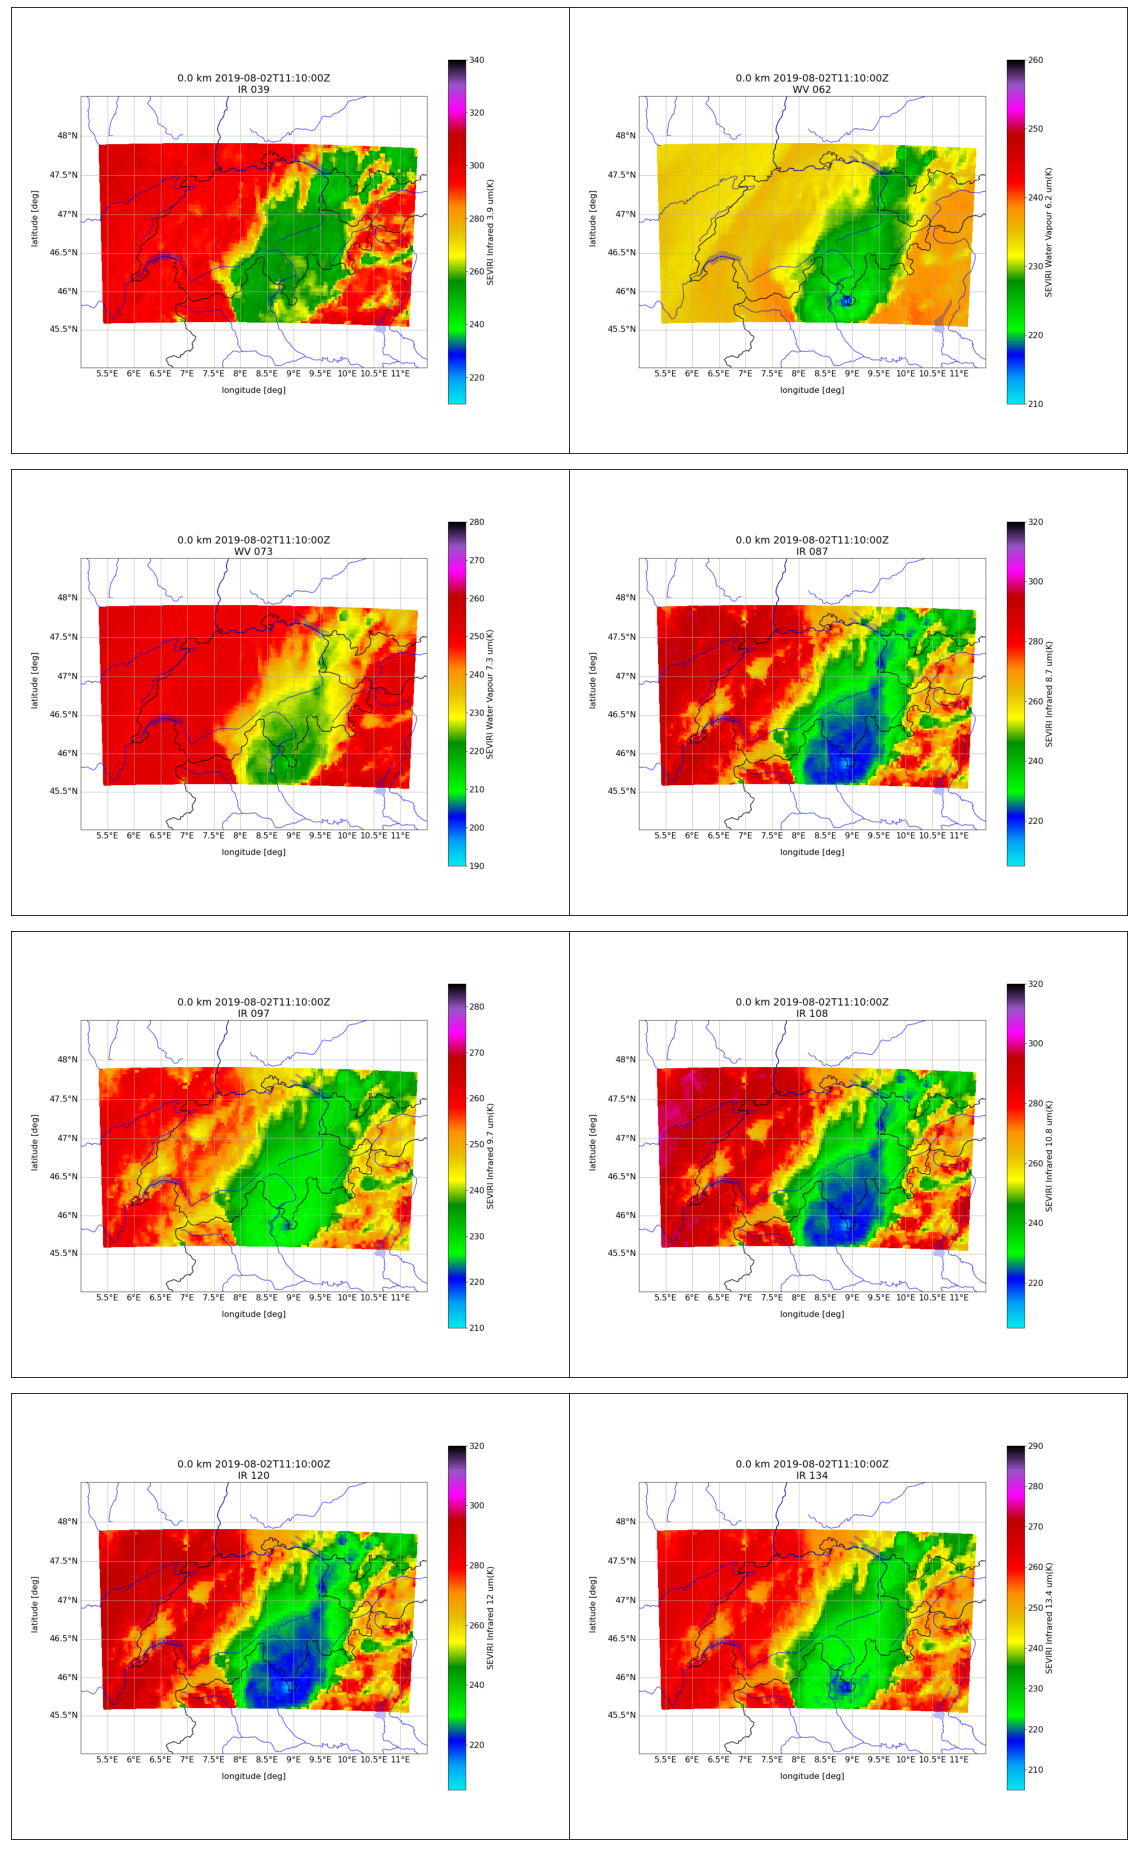

In [17]:
variable = ['IR_039', 'WV_062', 'WV_073', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134']
ncols = 2
nrows = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 34))

for i, var in enumerate(variable):
    img = Image.open('./figures/20190802/20190802111000_surface_RAW_GRID_'+var+'_l0.png')
    irow = int(i/ncols)
    icol = int(i%ncols)
    axes[irow, icol].imshow(img)
    axes[irow, icol].set_xticks([])
    axes[irow, icol].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

We plot below some of the channel differences used in literature, e.g. the differences between IR 9.7, 12, 13.4 and 6.2 and 10.8. The differences between IR 9.7, 13.4 and 6.2 and 10.8 seem to correlate well with areas with overshooting tops. The differences between 12 and 10.8 is primarily used to distinguish water and ice cloud tops, which it does well, but there is no indication of the OT within the anvil.  

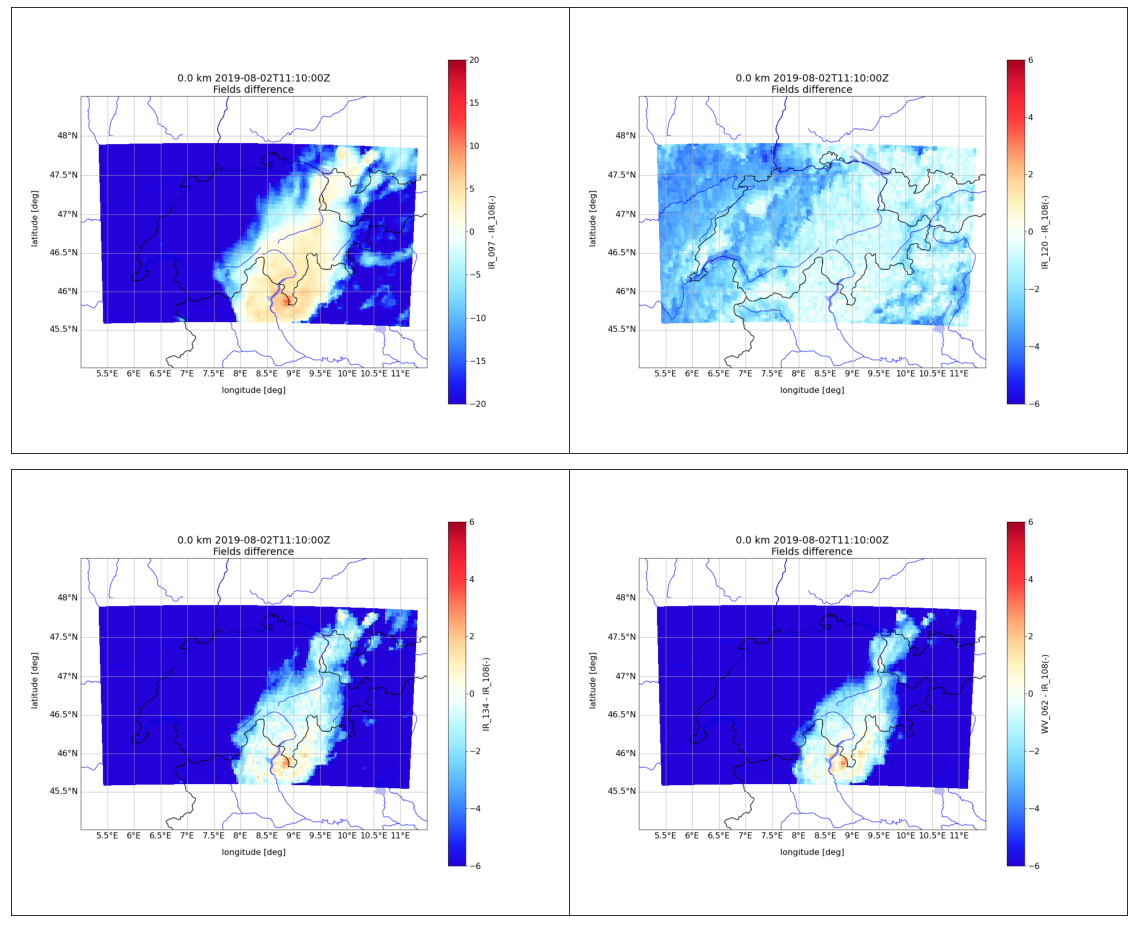

In [18]:
variable = ['IR_097-IR_108', 'IR_120-IR_108', 'IR_134-IR_108', 'WV_062-IR_108']
ncols = 2
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 17))

for i, var in enumerate(variable):
    img = Image.open('./figures/20190802/20190802111000_surface_GRID_FIELDS_DIFF_'+var+'_l0.png')
    irow = int(i/ncols)
    icol = int(i%ncols)
    axes[irow, icol].imshow(img)
    axes[irow, icol].set_xticks([])
    axes[irow, icol].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Below we can see satellite imaginery with the contour of the mask at POH90 overplotted. Pixels with POH90 have been expanded by one on each side in the west-east direction and 2 on each side in the south-north direction

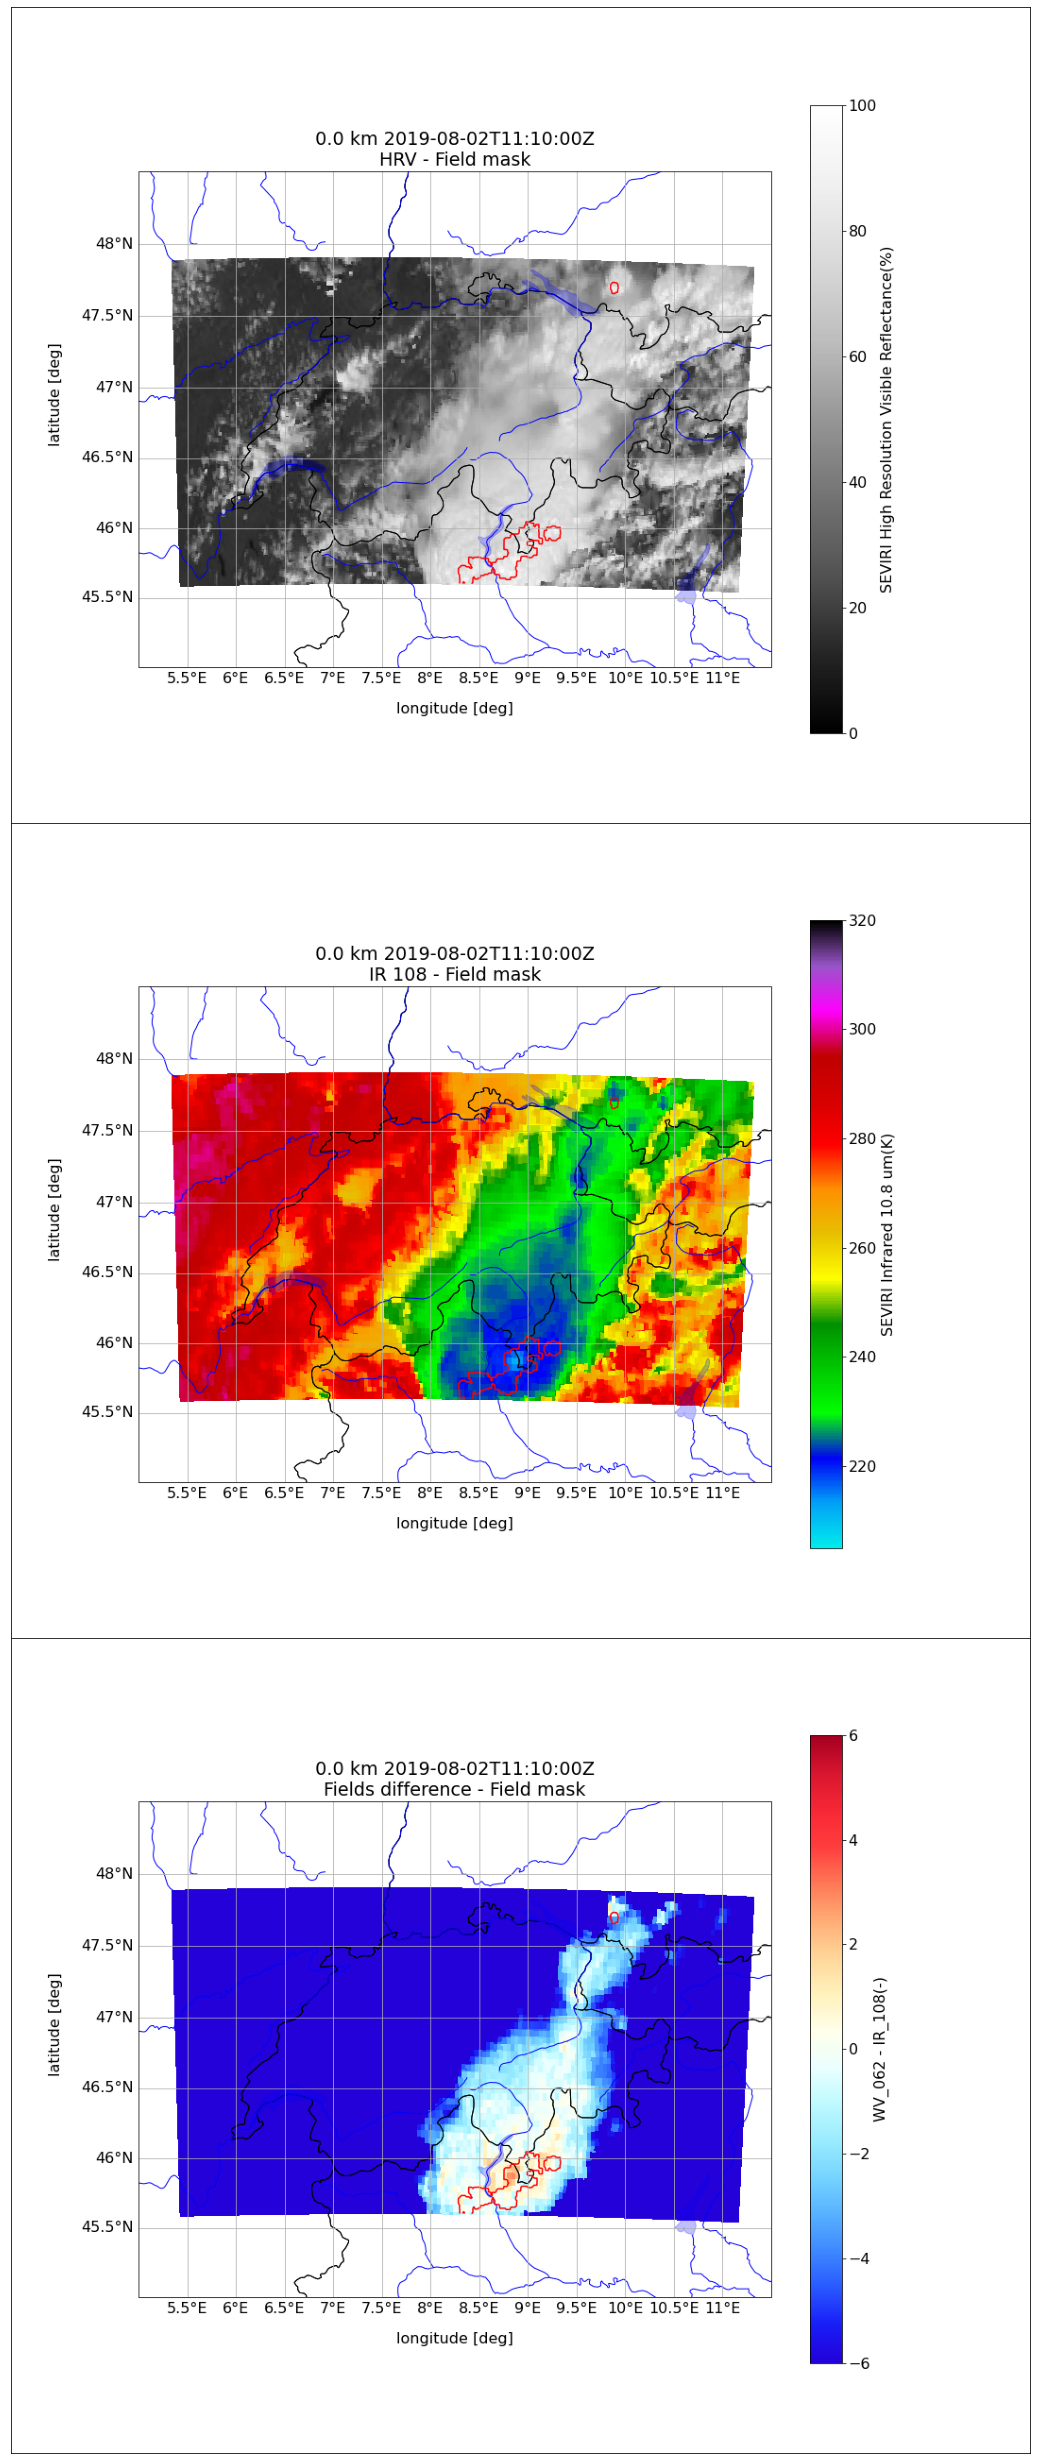

In [19]:
variable = ['HRV-mask', 'IR_108-mask', 'diff-mask']
ncols = 1
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 45))

for i, var in enumerate(variable):
    img = Image.open('./figures/20190802/20190802111000_surface-contour_RAW_GRID_'+var+'_l0.png')
    irow = int(i/ncols)
    icol = int(i%ncols)
    axes[irow].imshow(img)
    axes[irow].set_xticks([])
    axes[irow].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Histograms of the data

We explore here the histograms of the data for the 3 channels that contain most information on hail, that is the infrared 10.8 (hereby also IR_108), the difference between water vapour and the infrared 10.8 (hereby window channel or WV_062-IR_108) and the high resolution visible (non-normalized, HRV, and normalizedby the sun position, HRV_norm). For convinence we have divided the data in 512 bins with ample margins instead of the quantization to 10 bits from the original data.

First we comment on the histograms resulting from pooling all the data together (first column in the figures below). IR_108 data exhibits a bimodality with one peak at roughly 230 K and the other at 290K. The data range expands from 200 to 311 K. The window channel has 2 peaks at roughly -60 K and 0 K and a secondary one at 40 K. The data range expands from -78 K to 8.4 K. The high resolution visible channel exhibits a log-normal distribution with the peak roughly at 15%. When normalized by the sun position, a very clear peak at around 20% clearly emerges. A second peak at 100% can be seen which clearly indicates that a large percentage of the data becomes saturated when normalizing.

Due to the fact that a very large percentage of the pixels in the images do not contain hail there are no visible differences between the histograms of all the data pulled together and that of no-hail data. The pixels containing hail are characterized by low values of IR_108. The distribution has a log-normal shape with a peak at roughly 215 K and a large tail. The range of values in the histogram extends from 202 to 295 K. The window channel has a very large peak at 0.8 K. On the positive differences it decreases very rapidly up to the range of 8.4 K whereas the negative side has a fat tail reaching -63.2 K. The HRV channel has an almost uniform distribution between 20 and 80%, however when normalized by the sun position the distribution becomes Gaussian with a peak at 90% and many values above 100%. In the plot this shows as a large peak at 100% since the histogram is truncated at 100%.

The histograms of the textures of these variables have been computed and analyzed in [notebook 03_hist_1D](./03_hist_1D.ipynb). Overall it can be said that, although with a large overlap, the histograms of pixels in areas with hail have distinguishable characteristics.

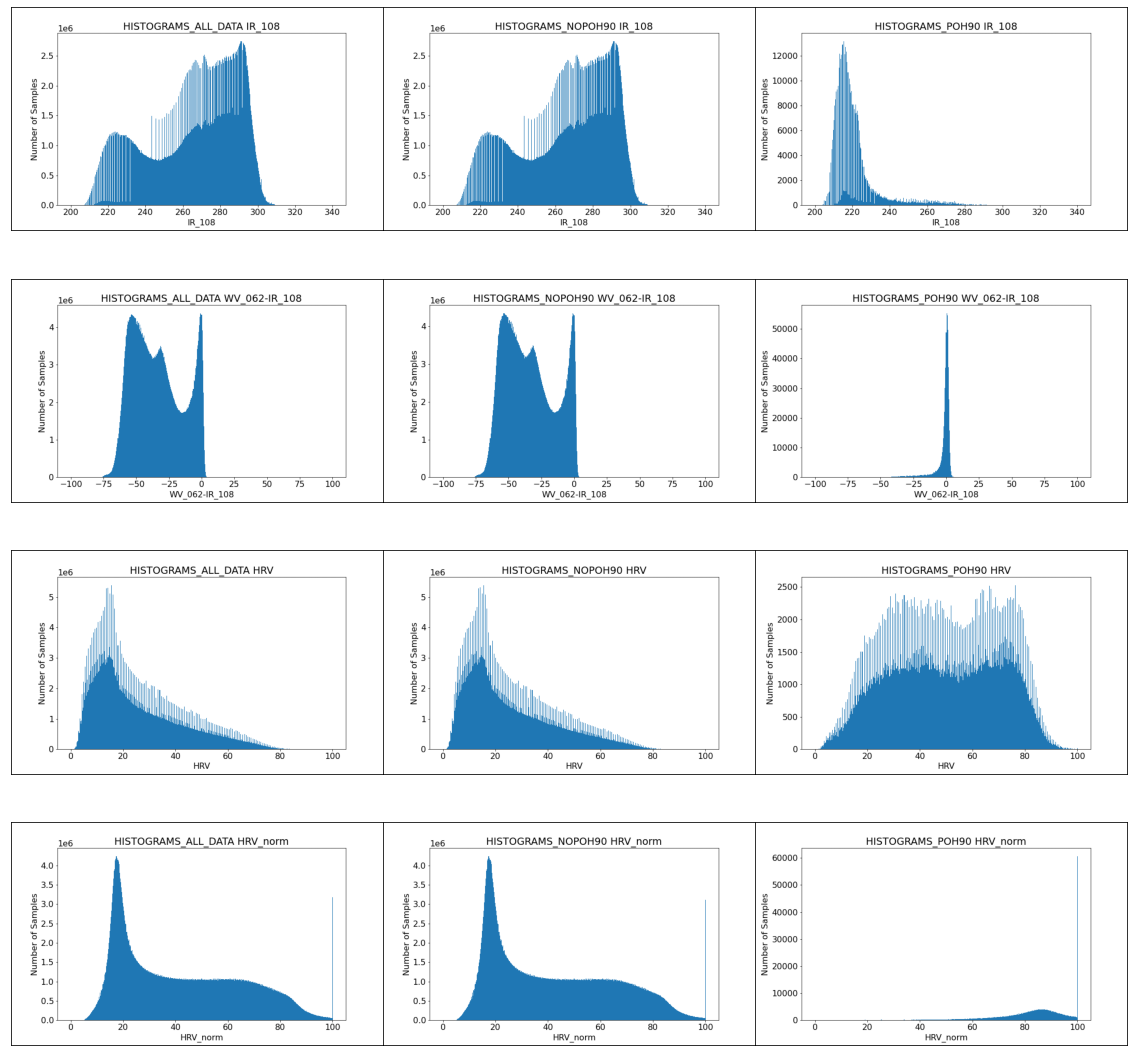

In [20]:
variable_col = ['ALL_DATA', 'NOPOH90', 'POH90']
variable_row = ['IR_108', 'WV_062-IR_108', 'HRV', 'HRV_norm']
ncols = 3
nrows = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))

for icol, var_col in enumerate(variable_col):
    for irow, var_row in enumerate(variable_row):
        img = Image.open('./figures/HISTOGRAMS_'+var_col+'_'+var_row+'.png')
        axes[irow, icol].imshow(img)
        axes[irow, icol].set_xticks([])
        axes[irow, icol].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Further analysis have been performed in [notebook 04_hist_2D](./04_hist_2D.ipynb). This time, 2D histograms relating the different variables have been computed. The 2D histograms show a differentiate distribution between hail and no hail pixels although there is significant overlap. 

## 4) Machine learning 

### (a) Phrase your project goal as a clear machine learning question

In terms of machine learning this is a classification problem. The objective of the project is to identify areas with hail on the ground from satellite imaginery through the identification of typical cloud structures such as overshooting tops. Therefore, there will be two kinds of pixels as output: hail pixels and non-hail pixels.

The features that were used initially were the HRV, 10.8 $\mu m$ infrared and the difference between 6.2 and 10.8 $\mu m$ channel. Later on an additional variable, 1.6 $\mu m$ infrared, which is a good indicator of cloud top phase was added to the dataset and the most performing models were retrained using this variable.

The target variable is a mask covering the same area as the satellite with "True" for pixels with POH above 90% and "False" for anything else.

### (b) What models have you used and why?

Since this is a classification problem, at pixel level classical classification techniques such as k-nearest neighbors, logistic regressions, random forests or support vector machines (SVMs) can in principle be explored. A binary decision (hail/no hail) has to be taken in the end. Since there is a considerable overlap of the histograms of pixels containing hail from those not containing any hail non-linear techniques such as random forests or support vector machines seem to be better suited to tackle the problem. One issue to consider is that the number of pixels in the training dataset is rather high (3600 images of 448x256 pixels, i.e. 412'876'800). It is also a highly imbalanced problem with very few pixels containing hail. The imbalance problem can be partially tackled by focusing on areas that are more likely to have OTs, i.e. excluding areas with high IR_108 or very negative channel differences. That would also reduce significantly the number of pixels in the training since less than half the pixels are below this threshold. In any case, random forests are typically better scalable than SVMs. Consequently we use random forests as a basic model candidate. It is clear from the images above that a lot of information on OTs is contained in the spatial structure rather than in the individual pixels. In order to add spatial information as a feature a 7x7 local standard deviation window will be applied on each variable.

Despite the use of the local standard deviation in the random forest model, deep-learning techniques are more suitable to capture the spatial structures. Our problem can be described in terms of a classical image segmentation problem where we want to assign to each pixel in the domain whether it has a satellite image feature that contains hail or not. The main difference is that, whereas typical image classification problems use 3 channels (RGB), here potentially more channels are available because infrared and eventually other data can be used. The best suited ML technique for this sort of problems is the convolutional neural network (CNN). Various implementations have been proposed in literature such as the U-NET or the Deeplab v3. Exploring the resources available in the Internet, we have identified an implementation of the [U-NET architecture in Tensorflow 2](https://github.com/jakeret/unet) that might be a very suitable model since it offers flexibility in terms of the size of the images and the number of input channels.

Summarizing we use two different models to tackle the problem: a conventional machine learning algorithm, the random forest and a deep learning algorithm, U-NET. 

### (c) Please tell us your detailed machine learning strategy 

## Pre-processing of the data

### a) Random Forest dataset

The pre-processing of the random forest dataset was performed in [notebook 05_RF_data](./05_RF_data.ipynb). It consisted in extracting all pixels which were likely to contain hail in the image. According to the histograms hail was more likely at IR_108 temperatures below 240 K and window channel temperatures above -50 K. These are the thresholds used to extract the pixels of interest. A features matrix with 6 columns corresponding to the features HRV_norm, HRV_norm_text, IR_108, IR_108_text, window channel and window channel texture was created from the raw data archive. The corresponding target matrix was a single column matrix with values 0 (No POH), 1 (POH below 90%) and 2 (POH at or above 90%). One pair of features-target matrices was created for each month examined and stored in a numpy .npz file. An example of such file can be seen in folder ./data/rf_data/. The size of these files was to big to be uploaded to a github repository but they are available on demand. Notice that NaN values were kept at this stage in the processing so that it could be decided a-posteriori whether they would be kept or filtered out. Also the target matrix is converted on the fly into a hail/no hail target by mapping 0 and 1 to 0 (no hail) and 2 to 1 (hail).

At a later stage, another pair of features (IR_016 and IR_016_text) were added and another dataset created following the same procedure described above. This was performed in [notebook 15_RF_data_expanded](./15_RF_data_expanded.ipynb). An example of the files generated can be seen in folder .data/rf_data_expanded.

### b) U-NET dataset

The pre-processing of the U-Net dataset was performed in [notebook 06_DL_data](./06_DL_data.ipynb). Basically a min-max normalization was applied to all the features. The minimum and maximum values were obtained from those in the histograms computed and from those obtained from the dedicated [notebook 02_min_max](./02_min_max.ipynb). The features were put in a features matrix of shape (nx, ny, nchannels). As with the Random Forest dataset, the POH90 data was transformed into a set of 0 (no hail) and 1 (hail) values. As required by the u-net software package, the target matrix was hot-encoded. Consequently, the target matrix had the shape (nx, ny, nclasses). The features and target matrices are stored in a numpy .npz file. A file per time step was created. And example of such file can be seen in ./data/dl_data/. Due to the large size of the dataset it has not been uploaded to the repository but it is available on demand.

At a later stage a new dataset with the additional feature IR_016 was created using [notebook 23_DL_data_expanded](./23_DL_data_expanded.ipynb). An example of the files created can be seen in ./data/dl_data_expanded/.

## Metrics

This being a classification problem, we are mainly interested in the probability of detection, i.e. the ratio of hail pixels correctly identified and the false alarm rate, i.e. the ratio of pixels uncorrectly identified as hail. A sophisticated model by [Bedka and Khlopenkov (2016)](https://journals.ametsoc.org/jamc/article/55/9/1983/14245/A-Probabilistic-Multispectral-Pattern-Recognition) reports a probability of detection respect to human identified OTs of 69% and a false detection rate of 18%. We can use these numbers as our baseline.

Since it is relatively straighforward in case of a binary decision, we visualize the whole confusion matrix. Considering the high imbalance between non-hail and hail pixels, it is also convenient to focus on the positive predictive value or precision (i.e. the ratio between True Positives and the sum of True Positives and False Positives).

## Training and fine tuning of the models

### a) RF models family

For the random forest family of models we have tuned the number of estimators used. The large dataset and the limited computing resources available made training the models rather costly. Therefore whe have performed an sparse grid search. The tunning was in the range betweeen 1 and 50 trees. From 1 to 20 there was a step of 2 and from 20 to 50 the step was increased to 10. We made a 5-fold shuffle&split cross-validation to avoid using data that may be correlated in time.

### b) U-net architecture

The U-NET architecture has several parameters that can be tuned:
* layer_depth: the total number of layers of the U-NET. The default is 5.
* filters_root: the number of kernels in the top layer. This number is doubled at each successive layer. The default is 64.
* kernel_size: the size of each kernel. The default is 3.
* dropout_rate: the rate of dropout. Default is 0.5.
* padding: padding to be used in the convolutions. The default is 'valid' i.e. no-padding. It can be also set to 'same' (0-padding)
* activation: type of activation to be used. The default is 'relu'. In principle any activation functions implemented in tensorflow can be used.
* pool_size: The size of maxpool layers. Default is 2.

In principle there are many parameters that may be tunable. However, it seems clear that the most relevant parameters are the number of layers and the number of kernels at each layer. A major constraint when exploring the hyperparameters space is the training time for each layer. We wanted to explore in depth the effect of changing the layer depth and the number of kernels. We wanted to use GPUs to speed up the training but a major stumbling block was the fact that the u-net software package was compatible with tensorflow versions 2.1 or higher whereas our workstation containing GPUs was setup for tensorflow version 2.0.0. It was not possible to update the workstation setup because other operational processes were running on it so we had to use 8 CPUs only. 

Due to these facts we only explored an architecture with 3 layers and 16 and 64 kernels in the top layer respectively. It should be noticed that we did an attempt at an architecture with 5 layers but we encountered the following error:

````
[0;31mInvalidArgumentError[0m:  ConcatOp : Dimensions of inputs should match: shape[0] = [1,73,25,64] vs. shape[1] = [1,72,24,64]
	 [[node unet/crop_concat_block_1/concat (defined at /home/fvj/.pyenv/versions/3.7.9/envs/MSG_ML/lib/python3.7/site-packages/unet/unet.py:117) ]] [Op:__inference_predict_function_1442]

Errors may have originated from an input operation.
Input Source operations connected to node unet/crop_concat_block_1/concat:
 unet/crop_concat_block_1/strided_slice_6 (defined at /home/fvj/.pyenv/versions/3.7.9/envs/MSG_ML/lib/python3.7/site-packages/unet/unet.py:112)	
 unet/upconv_block_1/activation_13/Relu (defined at /home/fvj/.pyenv/versions/3.7.9/envs/MSG_ML/lib/python3.7/site-packages/unet/unet.py:90)

Function call stack:
predict_function
````

(see file [nohup_ld5_fr16](./unet_models/nohup_ld5_fr16.out) for the complete output). We suspect that was a bug in the code and there was an error in the rounding of the input data shape.

## Models results

### a) RF models family

Our first approach to the problem was a naive attempt to solve it using classical random forests models (see [notebook 07_RF_model](./07_RF_model.ipynb)). The metric to optimize in the grid search was the accuracy. The results showed a lack of sensitivity towards the presence of hail, the POD was only 29.185% while the FAR was also very low, 0.026%. Clearly that was a consequence of the high imbalance of the dataset (only 0.8% of the pixels in the dataset contained hail). In view of this fact, our second approach was to change the metric to optimize to the balanced accuracy (see [notebook 08_RF_model_balanced_accuracy](./08_RF_model_balanced_accuracy.ipynb)). As expected, this resulted in an improvement of the POD (36.173%), at the expense of the FAR (0.540%). It is noteworthy that the best score was achieved with a single tree and the performance was decreasing fast when increasing the number of trees.

Clearly, changing the parameter to optimize was not enough to achieve reasonable results. Therefore the next attempts tried to modify the model itself to make it more sensitive to the minority class. The first attempt in this sense was to use a class weighted random forest ([09_RF_class_weighted_model](./09_RF_class_weighted_model.ipynb)) whereby weights are used to penalize more the missclassifaction of the minority class. The weights are inversely proportional to the distribution of each class in the entire dataset. Surprisingly, the performance of this model in terms of POD was actually worse than the previous one, only 30.916% of hail was correctly detected when using the best model, which was constituted by a single tree. If weighting the data according to the distribution in each bootstrap sample ([10_RF_bootstraph_class_weighted_model](./10_RF_bootstraph_class_weighted_model.ipynb)) the results were only marginally better.

Better results were achived when manipulating the population given to the model when training so that both classes are better represented. These techniques are implemented in an extension of scikit-learn called [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html). Our first experiment was performed using the balanced random forest (see notebook [11_balanced_RF_model_balanced_accuracy](./11_balanced_RF_model_balanced_accuracy.ipynb)). This technique consists in randomly undersampling the majority class in each bootstrap sample. With this technique we achieved a very good POD of 95.287% at the expense of increasing the FAR up to 13.739%. The best results were obtained using 40 trees. Another model applying the same principle is the [Easy Ensamble](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html#imblearn.ensemble.EasyEnsembleClassifier). This algorithm creates subsets of data using as input all the samples of the under-represented class and a random undersampling of the majority class. It then uses the AdaBoost algorithm to minimize the errors in the classification of the minority class. We implemented the model in notebook [12_easy_ensemble_RF_model](./12_easy_ensemble_RF_model.ipynb). The performance of this algorithm was acceptable (85.432% POD and 17.362% FAR) but worse than the balanced RF.

Once it was determined that the balanced RF was the best model we experimented grid searches optimizing different scores. In particular we made a grid search optimizing the F-score (notebook [13_balanced_RF_model_f1](./13_balanced_RF_model_f1.ipynb)) and the precision ([14_balanced_RF_model_precision](./14_balanced_RF_model_precision.ipynb)). Both models obtained the same result, a slightly worse POD (94.693%) but better FAR (13.412%) than that obtained by optimizing the balanced accuracy. These results were obtained using 20 trees instead of the 40 trees needed when optimizing by balanced accuracy.

A final experiment consisted in increasing the number of features by adding channel IR_016, which provides information about cloud top phase, and its texture. We trained the new dataset using the balanced RF model and performing a grid search to optimize the F-score. The choice of the score was motivated by the fact that, although the POD was marginally worse, the positive predictive value was better. The training was implemented in notebook [16_balanced_RF_model_f1_expanded](./16_balanced_RF_model_f1_expanded.ipynb). The results were indeed very encouraging, the POD increased up to 96.110% while the FAR decreased significantly, down to 9.053%. These results are deemed acceptable for our applications.

We also had a look at the performance on individual time steps of the best model, i.e. the balanced RF model with an expanded number of features. The results of this analysis can be seen in notebook [17_RF_model_results](./17_RF_model_results.ipynb). What we can see is that the model does correctly locate hail in areas where its presence could be likely but tends to overestimate the extension of the hail area.

One of the advantages of using the RF model is that it is easy to identify the features that contribute the most to the results. When using a 3 channels plus 3 textures model the most important feature is the channel window, followed closely by the IR_108 and the normalized HRV. The textures also play an important role, with the texture of the normalized HRV being the most important which would hint at the fact that the spatial structure of the HRV channel contains a lot of information about the presence of hail. When adding feature IR_016 the two most relevant features are still the window channel and the IR_108 but then it is IR_016 and the texture of the normalized HRV those that are more important.

The figure below shows a bar plot summarizing the results of all the experiments.

In [21]:
RF_models = [
    'RF-accuracy', 'RF-balanced accuracy', 'class weigthed RF-balanced accuracy', 'bootstrap class weigthed RF-balanced accuracy',
    'balanced RF-balanced accuracy', 'easy ensemble-balanced accuracy', 'balanced RF-F1', 'balanced RF-precision',
    '8 features balanced RF-F1']
RF_POD = [29.186, 36.173, 30.916, 31.477, 95.287, 85.432, 94.693, 94.693, 96.110]
RF_FAR = [0.026, 0.540, 0.446, 0.420, 13.739, 17.362, 13.413, 13.413, 9.053]

df_RF = pd.DataFrame(data={'POD': RF_POD, 'FAR': RF_FAR}, index=RF_models)
df_RF.sort_values(by=['POD', 'FAR'], inplace=True, ascending=[True, False])
df_RF

POD     FAR
RF-accuracy                                    29.186   0.026
class weigthed RF-balanced accuracy            30.916   0.446
bootstrap class weigthed RF-balanced accuracy  31.477   0.420
RF-balanced accuracy                           36.173   0.540
easy ensemble-balanced accuracy                85.432  17.362
balanced RF-F1                                 94.693  13.413
balanced RF-precision                          94.693  13.413
balanced RF-balanced accuracy                  95.287  13.739
8 features balanced RF-F1                      96.110   9.053

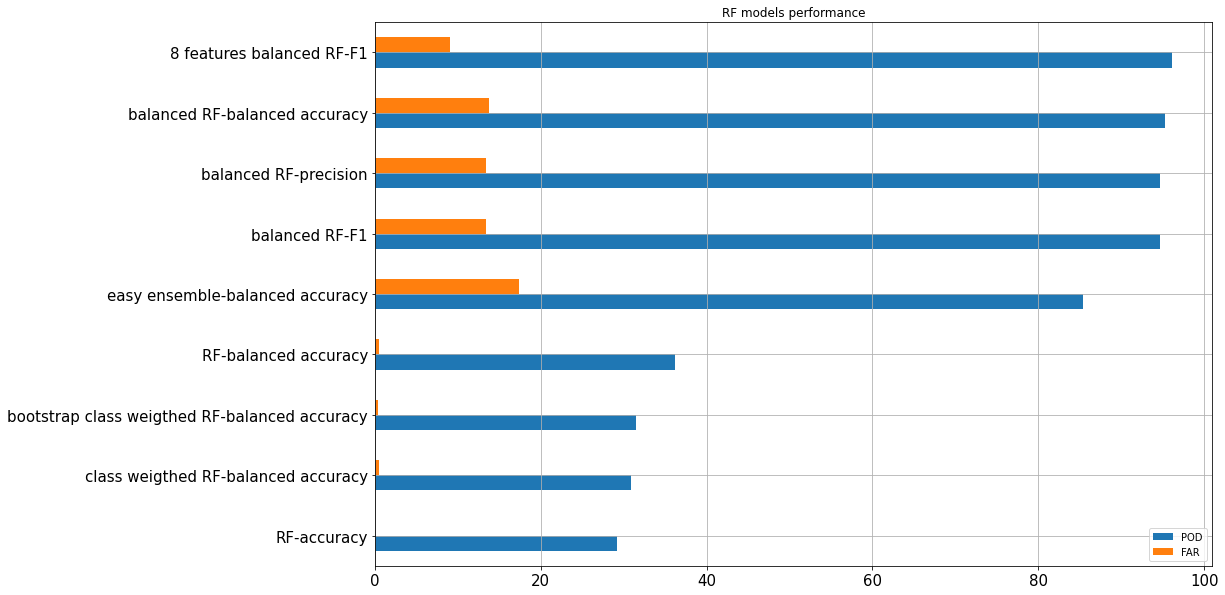

In [22]:
df_RF.plot.barh(figsize=(15,10), title='RF models performance', fontsize=15, grid=True)
plt.show()

### b) u-net models

The training of the models was performed on another workstation. Initially we intended to use the GPUs in the workstation but it turned out there was an incompatibility betweeen the tensorflow version required by the unet software package (2.1 or higher) and that required for the current configuration of the GPUs (2.0.0). Since it was not possible to change this configuration we did not use the GPUs but profited from the 8 CPUs available in that workstation.

Another technical issue was the fact that to access the workstation from the local laptop we had to create a tunnel through a second server. This configuration made the connection unstable and consequently the use of notebooks impractical. For this reason it was decided to use python scripts to train the model. The python script was created from the notebook [18_unet_model_tf2_training](./18_unet_model_tf2_training.ipynb). We stored the output messages during training in the files nohup_\[name of the model\].out that can be found in folder ./unet_models. Also during training it was saved the name of the files used for training, validation and testing, the training history as well as the resulting model. The analysis of the model was performed using notebooks.

The entire dataset consisting in 4351 images was divided randomly in testing (351 images), validation (400 images) and training (3600 images). To reduce the memory consumption a generator was implemented to access the data. The batch size was set to 32.

Since during the training of the random forest models it was observed that a major challenge was the high imbalance between classes and this imbalance was exacerbated by using the entire images instead of just a subset (only 0.1% of the pixels contained hail), it was decided from the beginning to use weighted binary cross-entropy to compute the losses of the model. The weights were inversely proportional to the frequency of each class in the training dataset. This resulted in quite extreme weights, on the order of 0.5 for the no hail class and 460 for the hail class.

The first model tested had a layer depth of 3 and 16 filters in the first layer. The model was training for a maximum of 100 epochs with an early stopping with a patience of 3 epochs without improvement. A detailed analyis of the results of this model can be found in [notebook 19_unet_model_performance_ld3_fr16](./19_unet_model_performance_ld3_fr16.ipynb). The model had a modest POD of 64.720% and a FAR of 1.227%. It is worth mentioning that the validation losses exhibited an erratic behaviour but with an increasing trend which would be a hint of overfitting. In fact the training stopped after 8 epochs. To investigate whether the increase in the validation losses was transient or it had a clear tendency we increased the patience to 6 epochs. The results of this experiment (see [notebook 20_unet_model_performance_ld3_fr16_p6](./20_unet_model_performance_ld3_fr16_p6.ipynb)) clearly showed that the validation losses were increasing and the model stopped after 11 epochs. The performace was slightly worse than with the first experiment in terms of POD (64.613%) although there was a minor improvement of the FAR (1.171%).   

The second model architecture tested had a layer depth of 3 and 64 filters in the first layer. The performance of this model was examined in [notebook 21_unet_model_performance_ld3_fr64](./21_unet_model_performance_ld3_fr64.ipynb). This model improved significantly the POD, up to 80.704%, while only slightly increasing the FAR (1.998%). However, again the validation losses have the tendency to increase and the training stopped after just 5 epochs.

We made an attempt to counter-balance the suspected overfitting of the model by using less extreme weights when computing the losses. We used a 1/10 proportion with the weight of the no hail class set to 0.56 and the weight of the hail class to 5. However, as shown in [notebook_22_unet_model_performance_ld3_fr64_udw](./22_unet_model_performance_ld3_fr64_udw.ipynb), this model completely lost the capability of detecting hail and assigned all pixels to the no hail class.

Our last experiment consisted in adding a new feature, IR_016, to the dataset. We trained the model using a unet architecture with a layer depth of 3 and 64 filters in the first layer, which was the one providing the best performance in terms of POD with the 3 features dataset. The analysis of the performance of this experiment can be seen in [notebook 24_unet_model_performance_ld3_fr64_expanded](./24_unet_model_performance_ld3_fr64_expanded.ipynb). The POD achieved by this model was actually worse than the one with just 3 features (69.948%) although the FAR was indeed reduced (0.956%). Again, validation losses had a tendency to increase after each training epoch and the training stopped after just 4 epochs.

Observing individual images it can be seen that, as with the RF family of models, the best u-net models do locate correctly areas where hail is possible, in the sense that they belong to storms, but they have the tendency to overestimate the extend of the hail.

The figure below summarizes the results obtained by the different models.

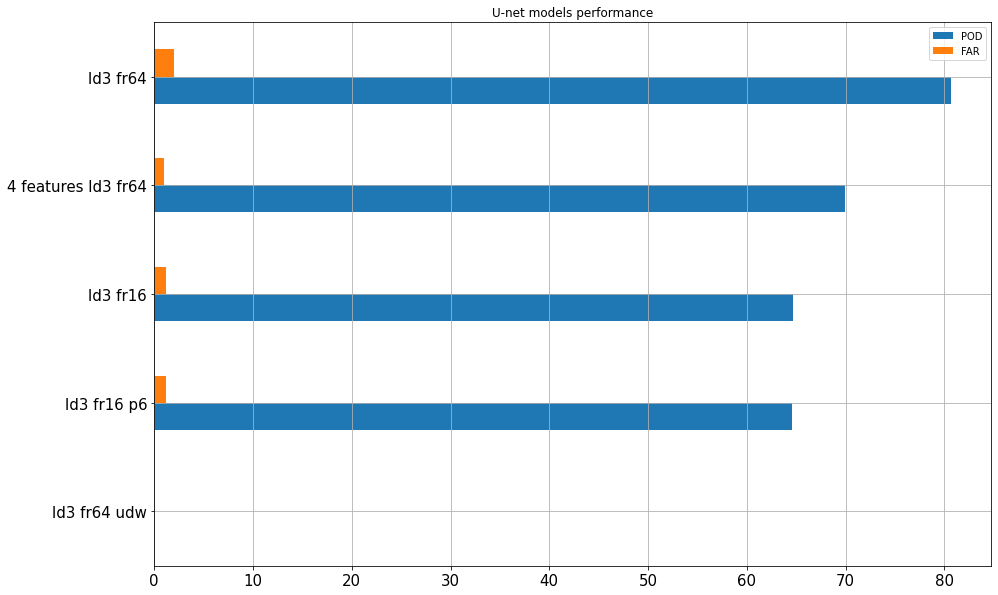

In [23]:
U_models = ['ld3 fr16', 'ld3 fr64', 'ld3 fr16 p6', 'ld3 fr64 udw', '4 features ld3 fr64']
U_POD = [64.720, 80.708, 64.613, 0., 69.947]
U_FAR = [1.227, 1.998, 1.171, 0., 0.956]

df_U = pd.DataFrame(data={'POD': U_POD, 'FAR': U_FAR}, index=U_models)
df_U.sort_values(by=['POD', 'FAR'], inplace=True, ascending=[True, False])
df_U

df_U.plot.barh(figsize=(15,10), title='U-net models performance', fontsize=15, grid=True)
plt.show()

# 5) Conclusion

The extreme imbalance between the hail-no hail classes, together with the large overlap in the distribution of each feature were major difficulties to tackle in the problem. The best "classical" machine learning model was the balanced random forest model, with very high POD and relatively moderate FAR. The best u-net model architecture that could be evaluated consisted on 3 layers with 64 filters in the first layer. Increasing the number of features proved beneficial for the balanced RF but had mixed results in the u-net architecture likely due to model overfitting.

The best classical model examined achieved better results than the best deep learning model although a one to one comparison between models is actually not possible since the classical model dealt only with a subset of all the pixels in the images.

The classical model, though, has a couple of advantages respect to the deep learning model. In the first place, since it is pixel-based, it can be re-used over an extended area within Europe since the only parameter depending on location is the normalization factor used for the HRV channel. It is also much faster to train and to make predictions with. Consequently, out of the models examined, the best model would be the balanced random forest optimized by F-score with 4 features.

Although not exceptional, the performance achived with the best models it is deemed sufficient for some applications like the flagging of hail-probable areas for further investigation.


# 6) Recommendations and suggestions for future work

The initial features used in this exercise were selected according to the information they provided as stated in the literature. However it was shown that increasing the number of features may be beneficial for the outcome of the models. The model performance when using all SEVIRI channels and several channel differences as well as subsets of those should be investigated thoroughly. Additional meta-information may also be included in the model such as satellite viewing angle, solar zenith angle, day of the year, solar time, etc.).

It should be also investigated if the use of more features prevents the over-fitting of the u-net model. In such case, more tests with different architectures should be performed. However, we strongly recommend to use a setup that allows the use of GPUs in the training to be able to effectively test the different combinations. The use of more CPUs in the training of the RF models would also be highly beneficial.

Another point that could be investigated further is the sensitivity of the models to the POH threshold. Furthermore, since it relies heavily on visible channels, the current models are valid during daylight only while a significant percentage of hail occurs during the night. Hence, it should be investigated whether a model using only features from the infrared channels can achieve reasonable performances.

Jupyter notebooks were useful for illustration purposes but we strongly recommend to implement the training and testing of the models as a python software package and/or python scripts and run them directly from local servers to avoid undesired interruptions in the processing.
